In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import hilbert, ShortTimeFFT, butter, filtfilt
from scipy.stats import kurtosis

In [2]:
faulty_df = pd.read_csv('data/FaultyMotorON.csv')

In [3]:
faulty_mic_data = faulty_df['Volt']
sr = 40000

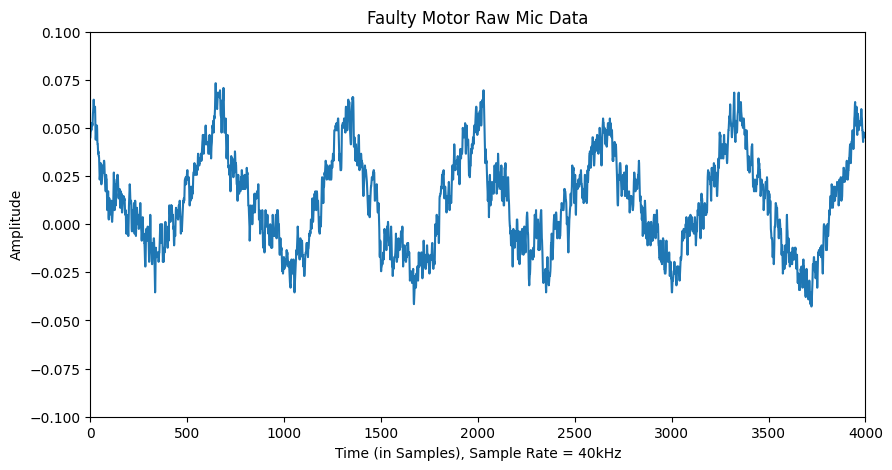

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(faulty_mic_data)
plt.title('Faulty Motor Raw Mic Data')
plt.xlabel('Time (in Samples), Sample Rate = 40kHz')
plt.ylabel('Amplitude')
plt.xlim(0, sr*0.1)
plt.ylim(-0.1, 0.1)
plt.show()

In [4]:
window = np.kaiser(sr, 10)
STFFT = ShortTimeFFT(window, hop=2000, fs=sr, scale_to='magnitude')
stft = STFFT.stft(np.array(faulty_mic_data))
abs_stft = np.abs(stft)
psd = abs_stft**2

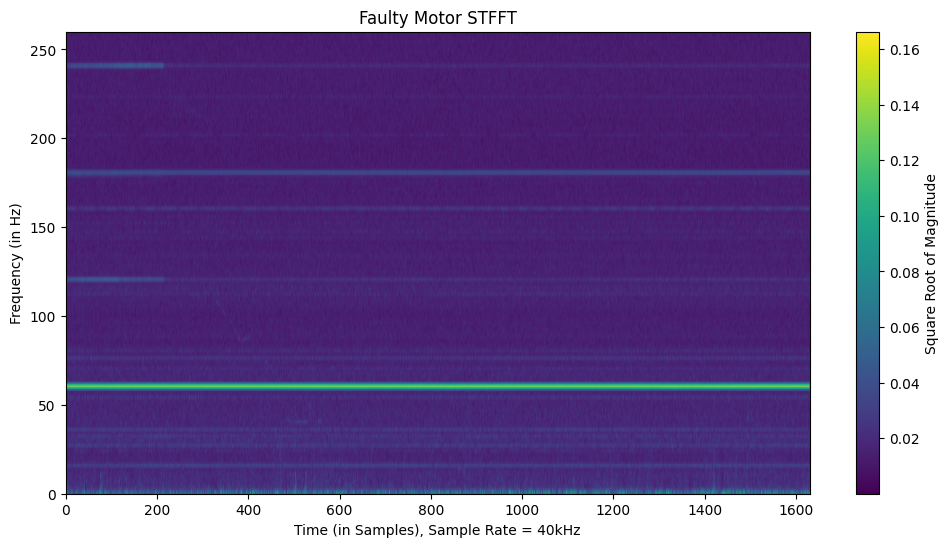

In [6]:
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_title('Faulty Motor STFFT')
ax1.set_xlabel('Time (in Samples), Sample Rate = 20kHz')
ax1.set_ylabel('Frequency (in Hz)')
ax1.set_ylim(0, 260)
im1 = ax1.imshow(abs_stft, origin='lower', aspect='auto', extent=STFFT.extent(faulty_mic_data.size), cmap='viridis')
fig1.colorbar(im1, label="Magnitude")
plt.show()

In [7]:
sk = kurtosis(psd, axis=1, fisher=True)

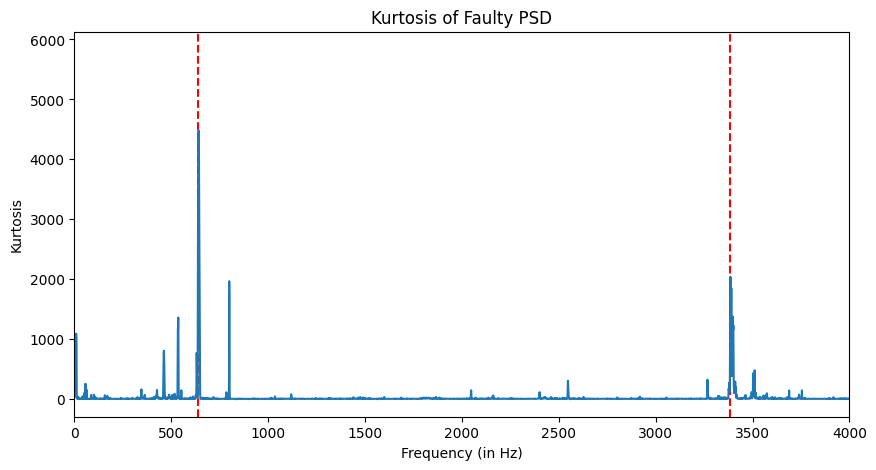

In [12]:
plt.figure(figsize=(10, 5))
plt.axvline(x=3386, color='red', linestyle='dashed')
plt.axvline(x=640, color='red', linestyle='dashed')
plt.plot(sk)
plt.title('Kurtosis of Faulty PSD')
plt.xlabel('Frequency (in Hz)')
plt.ylabel('Kurtosis')
plt.xlim(0, 4000)
plt.show()

In [13]:
# Define the center frequency and bandwidth of the band
center_freq = 640  # Center frequency in Hz
bandwidth = 150  # Bandwidth in Hz

# Calculate the lower and upper cutoff frequencies
lower_cutoff = center_freq - bandwidth/2
upper_cutoff = center_freq + bandwidth/2

# Design a bandpass filter
order = 4  # Filter order
fs = sr  # Sampling frequency
nyquist_freq = 0.5 * fs
low = lower_cutoff / nyquist_freq
high = upper_cutoff / nyquist_freq
b, a = butter(order, [low, high], btype='band')

# Apply the bandpass filter to the audio signal
bandpassed_signal = filtfilt(b, a, faulty_mic_data)

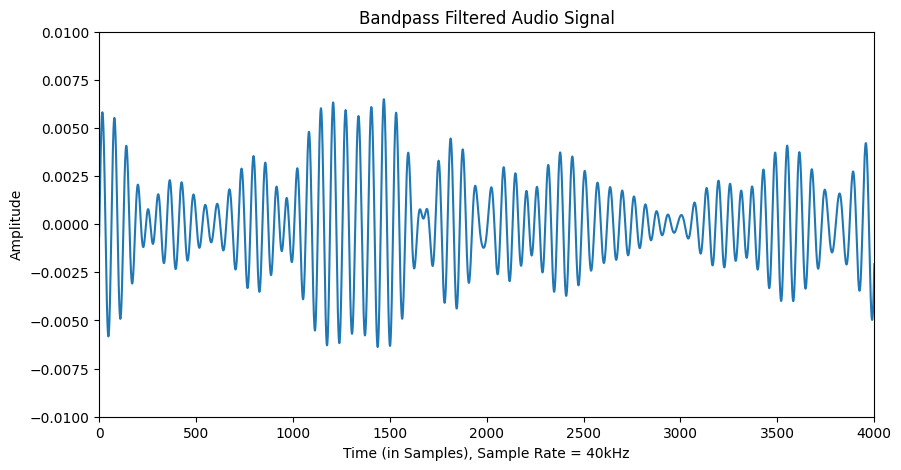

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(bandpassed_signal)
plt.title('Bandpass Filtered Audio Signal')
plt.xlabel('Time (in Samples), Sample Rate = 40kHz')
plt.ylabel('Amplitude')
plt.xlim(0, sr*0.1)
plt.ylim(-0.01, 0.01)
plt.show()

In [16]:
envelope = np.abs(hilbert(bandpassed_signal))

c:\Users\rarora\DataspellProjects\PredictiveAnalysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


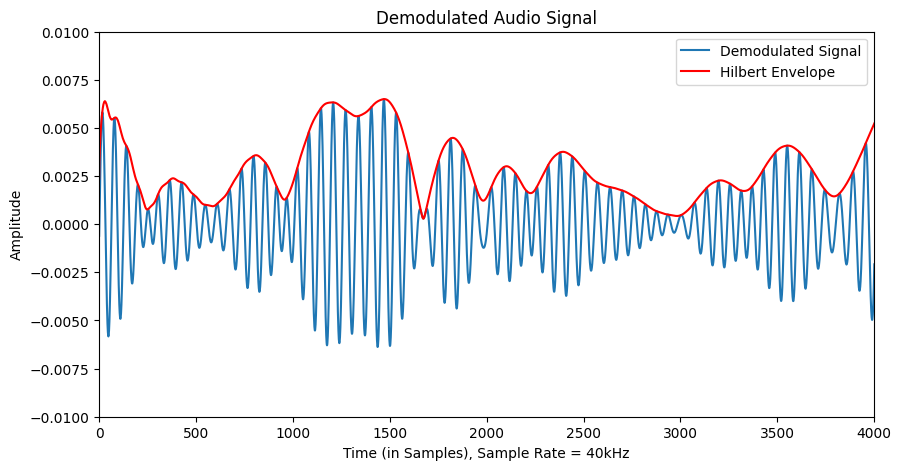

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(bandpassed_signal, label='Demodulated Signal')
plt.plot(envelope, color='red', label='Hilbert Envelope')
plt.title('Demodulated Audio Signal')
plt.xlabel('Time (in Samples), Sample Rate = 40kHz')
plt.ylabel('Amplitude')
plt.xlim(0, sr*0.1)
plt.ylim(-0.01, 0.01)
plt.legend()
plt.show()

In [27]:
window = np.kaiser(len(envelope), 10)
windowed_envelope = envelope * window
fft = np.fft.rfft(windowed_envelope, norm='forward')
freqs = np.fft.rfftfreq(len(windowed_envelope), d=1/sr)
fft_mag = np.abs(fft)

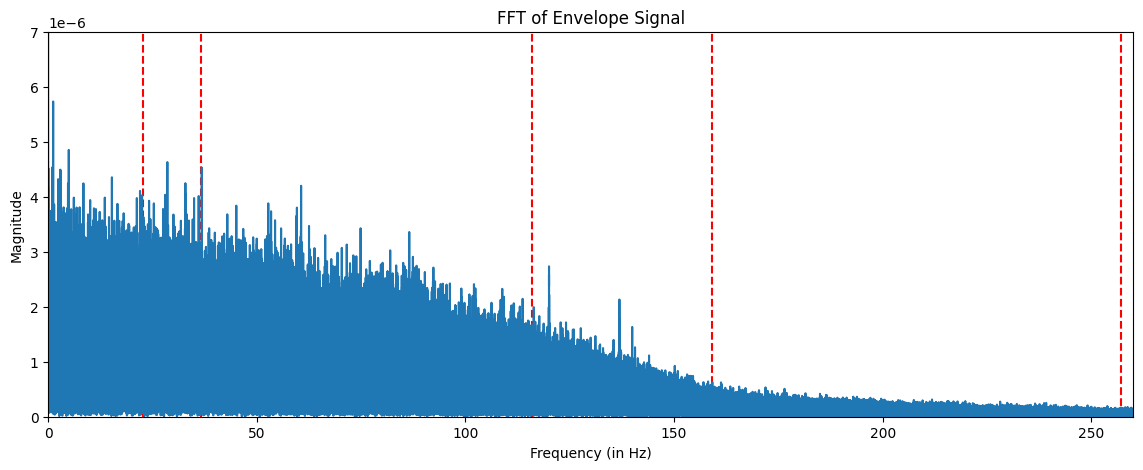

In [43]:
plt.figure(figsize=(14, 5))
plt.axvline(x=22.8, color='red', linestyle='dashed')
plt.axvline(x=36.7, color='red', linestyle='dashed')
plt.axvline(x=159, color='red', linestyle='dashed')
plt.axvline(x=257, color='red', linestyle='dashed')
plt.axvline(x=116, color='red', linestyle='dashed')
plt.plot(freqs, fft_mag)
plt.title('FFT of Envelope Signal')
plt.xlabel('Frequency (in Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 260)
plt.ylim(0, 0.000007)
plt.show()